In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [11]:
def calculate_kup1_composite(df, window_atr=20, volume_window=12, rsi_window=14):
    """
    复合因子：结合波动率、成交量和RSI的上影线因子
    公式：KUP1_Composite = ((high - max(open, close)) / (open * atr)) * volume_ratio * rsi_weight
    原理：低波动、高成交量、超买环境下的上影线信号更可靠
    """
    # 计算ATR（平均真实波幅）
    df['atr'] = ta.atr(df['high'], df['low'], df['close'], length=window_atr)
    
    # # 计算成交量比率
    # df['volume_ma'] = df['volume'].rolling(volume_window).mean()
    # df['volume_ratio'] = df['volume'] / df['volume_ma']
    
    # 计算RSI和超买权重
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    rsi_weight = np.where(df['rsi'] > 70, 1.5, 0.5)
    
    # 计算基础KUP1
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = df['high'] - max_open_close
    base_kup1 = upper_shadow / df['open']
    
    # 波动率调整
    kup1_vr = base_kup1 / df['atr']
    
    # 复合因子：波动率调整 * 成交量加权 * RSI权重
    kup1_composite = kup1_vr * rsi_weight
    
    # # 标准化因子值（减均值除标准差），确保平稳性
    # kup1_composite = (kup1_composite - kup1_composite.mean()) / kup1_composite.std()
    
    return kup1_composite

# 因子测试

In [12]:
evaluator.set_factor(
    factor_data_or_func=calculate_kup1_composite,
    factor_name='calculate_kup1_composite'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.013801
   Rank_IC (Spearman): 0.001221
📊 信息比率:
   IR: -0.184185
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130685
   因子列: calculate_kup1_composite
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


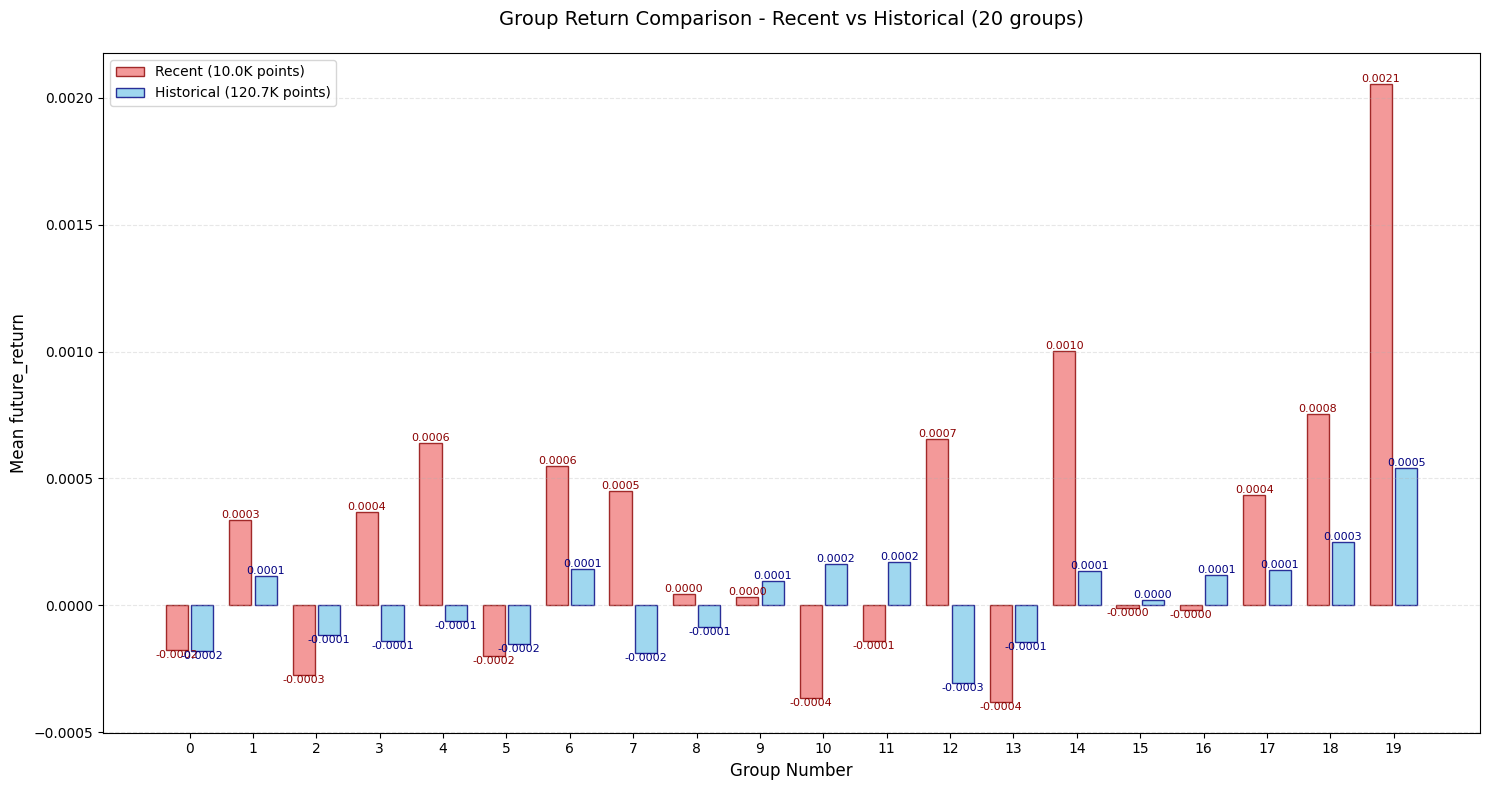

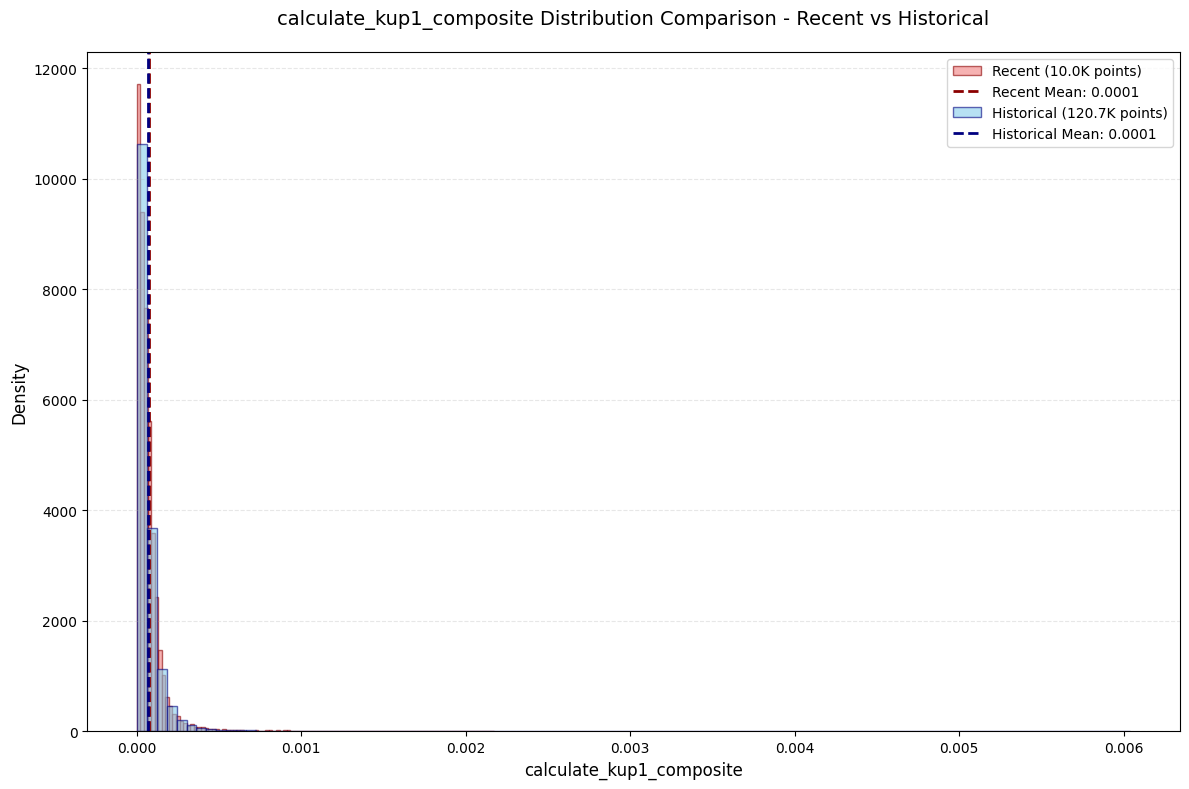

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [13]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)